# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости на основаии сравнения показателей нескольких моделей. Мы будем использовать RandomForestRegressor, CatBoostRegressor и LGBMRegressor, находя оптимальные гиперпараметры для каждой модели по критериям заказчика.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

При подборе гиперпараметров будем засекать время обучения и предсказания, а сам подбор осуществлять исходя из минимальной среднеквадратичной ошибки.

Данные находятся в файле /datasets/autos.csv и содержат следующие столбцы:

**Нецелевые признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
    
**Целевой признак**

- Price — цена (евро)
    
Данные нуждаются в предобработке, поэтому сперва произведем ее, затем обучение моделей и тестирование лучшей.

## Загрузка и подготовка данных

### Импорт данных

In [ ]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 49 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, train as trainLGBM
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.metrics import mean_squared_error as RMSE #sklearn.metrics.mean_squared_error(y_true, y_pred, Squared = False)

In [ ]:
data0 = pd.read_csv('/datasets/autos.csv')
data0.info()
data0.sample(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
250342,2016-03-19 22:52:24,7490,wagon,2010,manual,101,focus,125000,11,petrol,ford,no,2016-03-19 00:00:00,0,97204,2016-04-05 21:16:15
204509,2016-03-18 22:47:08,400,sedan,1997,manual,115,mondeo,150000,9,petrol,ford,NaN,2016-03-18 00:00:00,0,86676,2016-04-05 23:16:14
170433,2016-03-25 10:49:16,1500,small,1997,manual,101,a3,150000,3,petrol,audi,no,2016-03-25 00:00:00,0,9212,2016-04-04 09:46:14
340718,2016-03-15 11:49:26,2350,sedan,2001,auto,170,e_klasse,150000,6,NaN,mercedes_benz,no,2016-03-15 00:00:00,0,90431,2016-03-20 04:46:18
236229,2016-03-26 17:57:08,1000,small,2001,manual,0,almera,150000,10,petrol,nissan,NaN,2016-03-26 00:00:00,0,17179,2016-03-26 17:57:08
280560,2016-03-26 10:58:29,5290,sedan,2007,manual,105,golf,150000,2,gasoline,volkswagen,no,2016-03-26 00:00:00,0,24943,2016-03-31 06:16:46
73451,2016-03-13 21:37:23,12250,sedan,2011,manual,116,1er,60000,5,gasoline,bmw,no,2016-03-13 00:00:00,0,41836,2016-04-06 19:16:53


Данные содержат 16 колонок целочисленного (7) и строкового (9) типов, из которых 1 целевой признак Price (цена в евро), 15 нецелевых, среди них некоторые не являются значимыми (рассмотрим в след.пункте). Всего в датасете 354369 объектов, имеются пропуски в пяти столбцах. Далее произведем предварительный анализ и предобработку данных.

**Константы**

In [ ]:
RANDOM_STATE = 2023
RMSE_MAX = 2500

### Подготовка данных

Посмотрим на проценты пропусков, количество явных дубликатов, выведем гистограммы распределений столбцов для визуального анализа на аномалии и матрицу корреляции, найдем неинформативные столбцы

#### Дубликаты, пропуски

**Явные дубликаты**

Посмотрим на дубликаты и удалим их (поскольку полный повтор строки крайне маловероятен)

In [ ]:
display(data0.duplicated().sum())
display(data0[data0.duplicated()])
data = data0.drop_duplicates().reset_index(drop=True)
display(data.shape[0])

4

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


354365

**Неявные дубликаты**

Посмотрим на уникальные значения категориальных столбцов

In [ ]:
for col in ('VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'):
#list(pd.Series(data.isna().sum()).loc[pd.Series(data.isna().sum()) != 0].index):
#('VehicleType','Gearbox','Model','FuelType','Repaired'):
    print(col, data[col].sort_values().unique())#value_counts(),'\n')

VehicleType ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
Gearbox ['auto' 'manual' nan]
Model ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 

В типе топлива указаны два значения, имеющих одинаковый смысл (различающихся лишь страной использования): petrol суть одно и тоже с gasoline, оба бензин. Для моделей замечено два разных написания одной и той же модели: rangerover и range_rover. Заменим все вариации написаний на один вариант.

In [ ]:
data['FuelType'] = data['FuelType'].str.replace('gasoline', 'petrol')
data['Model'] = data['Model'].str.replace('rangerover', 'range_rover')
display(data['FuelType'].value_counts())
data['Model'].sort_values().unique()

petrol      315068
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

**Пропуски**


In [ ]:
round(pd.Series(data.isna().sum()).loc[pd.Series(data.isna().sum()) != 0] / data.shape[0] * 100, 2)

VehicleType    10.58
Gearbox         5.60
Model           5.56
FuelType        9.28
Repaired       20.08
dtype: float64

In [ ]:
data.loc[(data['Model'] == 'niva')&(data['VehicleType'].isna())]['VehicleType']

6191      NaN
6636      NaN
36018     NaN
101043    NaN
127167    NaN
134883    NaN
148860    NaN
172777    NaN
185838    NaN
190050    NaN
294621    NaN
308808    NaN
312181    NaN
332548    NaN
Name: VehicleType, dtype: object

Лучше всего было бы оставить эти пропуски со значением nan, так как нам наверняка неизвестно, что стоит за этими пропусками, а все столбцы являются значимыми. Для наглядности сначала заполним все пропуски индикаторным строковым значением "-", предварительно-таки удалив пропуски по названиям модели

In [ ]:
data = data.dropna(axis=0, subset=['Model'])
data = data.fillna('-')

Теперь попробуем заполнить пропуски по типам кузова популярным значением в группе с полным названием модели, выведя до и после количество пропусков

In [ ]:
# создадим столбец с полным наименовнаием модели из парных уникальных значений типа Марка+Модель
data['FullModel'] = data['Brand']+' '+data['Model']

# попробуем заполнить тип кузова по популярным значениям групп из полного названия модели
print(data.loc[data['VehicleType']=='-','VehicleType'].count())
for m in data['FullModel'].sort_values().unique():
    data.loc[(data['FullModel']==m)&(data['VehicleType']=='-'),'VehicleType'] = \
    data.loc[data['FullModel']==m,'VehicleType'].mode()[0]
data.loc[data['VehicleType']=='-','VehicleType'].count()

30662


10

Количество пропусков по столбцу с типом кузова с 30662 снизилось до 10

#### Аномалии, выбросы

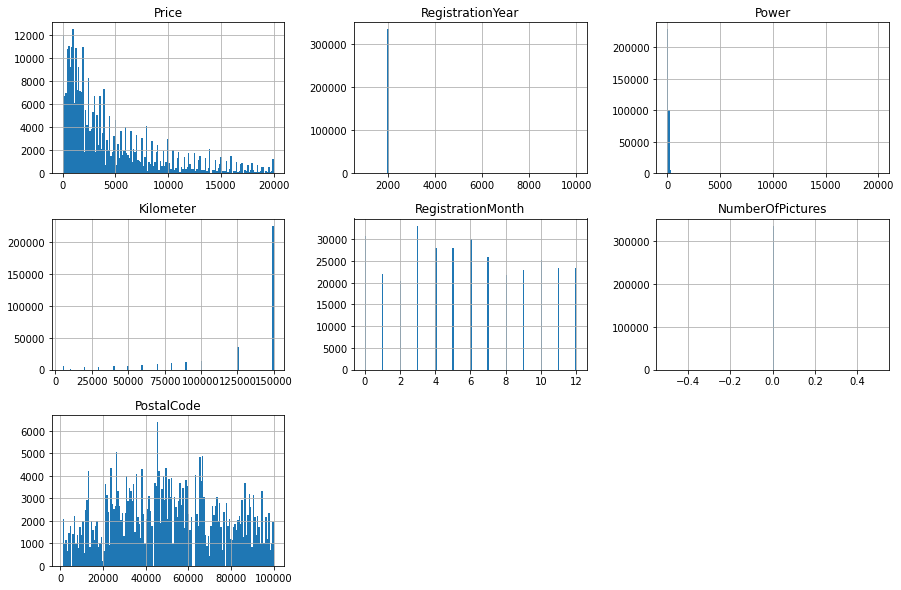

In [ ]:
data.hist(bins=150,figsize=(15,10));

**Цена**

В целевом столбце с ценой имеются нулевые выбросы (не заданная пользователем стоимость автомобиля). Такие строки следует исключить из рассмотрения. Выведем их количество и очистим датасет от них

count    334660.000000
mean       4504.372249
std        4531.457109
min           0.000000
25%        1150.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

8588

<AxesSubplot:>

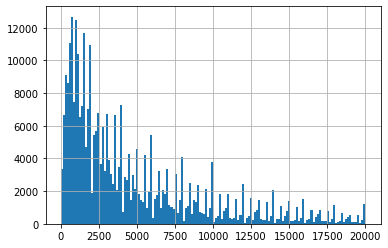

In [ ]:
display(data['Price'].describe())
display(data[data['Price']==0]['Price'].count())
data = data[data['Price']!=0]
data['Price'].hist(bins=150)

**Год регистрации автомобиля**

Рассмотрим аномальные значения в столбце с годом регистрации автомобиля: для начала обнаружим записи, в которых год регистрации превышает дату создания анкеты, выведя процент таковых в общем количестве объектов. Для них можно было бы поменять дату регистрации на год создания анкеты как раз, но будущая модель может неверно истолковать такие объекты, поэтому пока удалим такие записи

In [ ]:
display(round(data[data['RegistrationYear'] > pd.DatetimeIndex(data['DateCreated']).year]['RegistrationYear'].count()\
              / data.shape[0] * 100,2))
data = data[data['RegistrationYear'] <= pd.DatetimeIndex(data['DateCreated']).year]
data['RegistrationYear'].describe()

3.66

count    314152.000000
mean       2002.669014
std          10.312245
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

Посмотрим на уникальные значения столбцов. Ограничим год регистрации автомобиля снизу 1900-м и сверху 2016-м гг (верхняя граница обусловлена тем, что год регистрации автомобиля по логике не может превышать максимальный год создания анкеты), и удалим эти аномалии ввиду их незначительного количества

2016

array([1000, 1001, 1234, 1300, 1400, 1500, 1600, 1602, 1800, 1910, 1923,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1941, 1942, 1943, 1945, 1947, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

28

<AxesSubplot:>

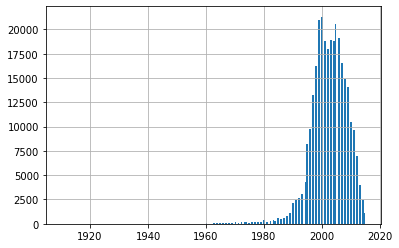

In [ ]:
display(max(pd.DatetimeIndex(data['DateCreated']).year))
display(data['RegistrationYear'].sort_values().unique())
display(data[(data['RegistrationYear'] < 1900) | (data['RegistrationYear'] > 2016)]['RegistrationYear'].count())
data = data[(1900 < data['RegistrationYear']) & (data['RegistrationYear'] < 2016)]
data['RegistrationYear'].hist(bins=200)

**Мощность двигателя**

Рассмотрим аномалии в столбце мощности двигателя. По гистограмме видно, что имеются выбросы вблизи нуля, а также значения простираются далеко за разумные 3000 л.с. Нулевые выбросы связаны, скорее всего, с незаполнением соответствующего поля пользователем, восстановить их можно попробовать через медианные значения в группе по полному названию модели. Пока удалим все остальные аномалии, заполнив нулевые выбросы медианой группы по модели и выведя количество ненулевых аномалий и нулевых выбросов.

122

26295

count    306235.000000
mean        120.567043
std          62.989115
min          11.000000
25%          77.000000
50%         110.000000
75%         147.000000
max        2799.000000
Name: Power, dtype: float64

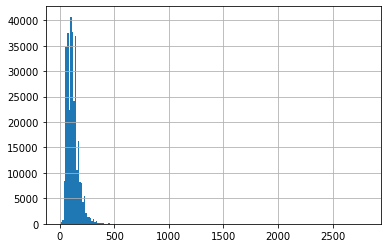

In [ ]:
display(data[(data['Power'] != 0) & ((data['Power'] < 10) | (data['Power'] > 3000))]['Power'].count())
display(data[data['Power'] == 0]['Power'].count())
for m in data['FullModel'].unique():
    data.loc[(data['FullModel']==m) & (data['Power']==0),'Power'] =\
    data.loc[data['FullModel']==m, 'Power'].mean()
data = data[(10 < data['Power']) & (data['Power'] < 3000)]
data['Power'].hist(bins=200)
data['Power'].describe()

**Процент удаленных строк**

In [ ]:
round((data0.shape[0] - data.shape[0]) / data0.shape[0] * 100, 2)

13.58

#### Корреляция признаков и информативные признаки

In [ ]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.530127,0.417725,-0.367264,0.081297,NaN,0.069375
RegistrationYear,0.530127,1.000000,0.132228,-0.286399,0.081691,NaN,0.038427
Power,0.417725,0.132228,1.000000,0.087972,0.038860,NaN,0.042005
Kilometer,-0.367264,-0.286399,0.087972,1.000000,-0.002371,NaN,-0.011146
RegistrationMonth,0.081297,0.081691,0.038860,-0.002371,1.000000,NaN,0.007297
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.069375,0.038427,0.042005,-0.011146,0.007297,NaN,1.000000


Числовые данные не имеют высоких показателей коэффициента Пирсона между собой, максимальная корреляция достигает 0.49 по модулю между целевым признаком и годом регистрации автомобиля, поэтому можем сделать вывод, что сильной линейной зависимости между численными признаками нет. Удалим незначимые для построения модели столбцы с датой создания и скачивания анкеты, количеством фотографий в объявлении, а также почтовым индексом владельца, датой последней активности пользователя и месяцем регистрации. Столбцы Brand и Model удалим ввиду создания обобщающего столбца FullModel

In [ ]:
data2 = data.drop(
    labels=['DateCreated', 'DateCrawled', 'NumberOfPictures',\
            'PostalCode', 'LastSeen', 'RegistrationMonth',\
           'Brand','Model'], axis=1
)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306235 entries, 0 to 354364
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             306235 non-null  int64  
 1   VehicleType       306235 non-null  object 
 2   RegistrationYear  306235 non-null  int64  
 3   Gearbox           306235 non-null  object 
 4   Power             306235 non-null  float64
 5   Kilometer         306235 non-null  int64  
 6   FuelType          306235 non-null  object 
 7   Repaired          306235 non-null  object 
 8   FullModel         306235 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 23.4+ MB


**Предварительный вывод**

В ходе предварительного анализа и предобработки данных были удалены явные дубликаты в количестве 4 штук и преобразованы неявные дубликаты в столбцах ТипТоплива и Модель, удалены пропуски по названиям модели, столбцы с брендом и моделью были объединены в одну колонку с полным названием модели, что позволило восстановить почти все пропуски по ТипуКузова; остальные пропуски заполнены маркерным значением '-'. Строки с нулевым значением цены удалены, год регистрации автомобиля ограничили сверху и снизу для исключения аномальных значений, нулевые выбросы по столбцу мощности автомобиля восстановили по среднему медианному значению группы полного названия модели. Незначимые столбцы удалены из рассмотрения, сильной линейной зависимости между числовыми столбцами не обнаружено. Процент удаленных строк 13,58%.

### Подготовка признаков и выборок

Подготовим выборки для обучения моделей: выделим целевой признак и остальные, а также разобьем датасет на обучающую, валидационную и тестовую выборки. Также необходимо будет произвести кодирование и масштабирование: первой моделью будет RandomForestRegressor, для которой будет использоваться порядковое кодирование признака Model, имеющего большое количество уникальных значений, и OHE кодирование остальных категориальных признаков. Для этого подготовим список численных и категориальных столбцов

In [ ]:
#разбивка данных на целевую колонку и нецелевые признаки
features = data2.drop('Price', axis=1)
target = data2['Price']
#train, valid, test = np.split(data.sample(frac=1, random_state=2023), [int(.6*len(data2)), int(.8*len(data2))])
#разбивка на тестовую, тренировочную и валидационную выборки в два этапа
f_train_valid, f_test, t_train_valid, t_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE
)
f_train, f_valid, t_train, t_valid = train_test_split(
    f_train_valid, t_train_valid, test_size=0.25, random_state=RANDOM_STATE
)
#проверка размерностей выборок
for smpl in (f_train, t_train, f_valid, t_valid, f_test, t_test):
    display(smpl.shape)

(183741, 8)

(183741,)

(61247, 8)

(61247,)

(61247, 8)

(61247,)

In [ ]:
#подготовка списков числовых и категориальных столбцов
numeric = features.select_dtypes(exclude='object').columns.to_list()
categorized = features.select_dtypes(include='object').columns.to_list()
print('Численные столбцы:', numeric,'\nКатегориальные столбцы:', categorized)

Численные столбцы: ['RegistrationYear', 'Power', 'Kilometer'] 
Категориальные столбцы: ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'FullModel']


In [ ]:
#посмотрим на различие в значениях категориальных столбцов тестовой и тренировочной выборок
print('Равенство значений тренировочной и тестовой выборок по категориальным столбцам:')
for col in categorized:
    print(col,(set(f_test[col]) >= set(f_train[col])),
          set(f_test[col]) ^ set(f_train[col]))
#категориальные признаки для OneHotEncoder и OrdinalEncoder модели RandomForestRegressor
ohe_features_rf = categorized.copy()
ohe_features_rf.remove('FullModel')
oe_feature_rf = ['FullModel']

Равенство значений тренировочной и тестовой выборок по категориальным столбцам:
VehicleType False {'-'}
Gearbox True set()
FuelType True set()
Repaired True set()
FullModel False {'lada samara', 'rover discovery', 'rover freelander', 'land_rover serie_2', 'rover defender'}


In [ ]:
# здесь же подготовим выборки для разных моделей
# переопределим выборки для Случайного Леса
f_train_rf = f_train.copy()
f_valid_rf = f_valid.copy()
f_test_rf = f_test.copy()
# для бустинговых моделей необходимо перевести категориальные данные в тип category
f_train[categorized] = f_train[categorized].astype('category')
f_valid[categorized] = f_valid[categorized].astype('category')
f_test[categorized] = f_test[categorized].astype('category')

## Обучение моделей

Обучим разные модели, одна из которых — LightGBM, рассмотрим также CatBoost, другая — не бустинговая (RandomForest). Для каждой модели попробуем разные гиперпараметры.

Для оценки качества моделей будем применять метрику RMSE.
Значение метрики RMSE должно быть меньше 2500 по условию проекта, эта константа уже объявлена в его начале.
Модель градиентного бустинга может долго обучаться, поэтому изменим у неё только два параметра.

### Случайный Лес

Гиперпараметры для Случайного Леса будем подбирать через RandomizedSearchCV с Pipeline для масштабирования численных и кодирования категориальных признаков

In [ ]:
%%time
## подбор гиперпараметров
# преобразование признаков:
col_transformer_rf = make_column_transformer(
# категориальные через OHE и OE для столбца с моделью,
    (OneHotEncoder(drop='first', handle_unknown='ignore'),
     ohe_features_rf),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
     oe_feature_rf),
# масштабирование через StandardScaler
    (StandardScaler(),
     numeric),
    remainder='passthrough'
)
# задаем модель, формируем пайплайн и определяем гиперпараметры для перебора
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
pipline_rf = make_pipeline(col_transformer_rf, model_rf)
param_grid_rf = {
    'randomforestregressor__n_estimators': range(20, 100, 20),
    'randomforestregressor__max_depth': range(2, 15)
}
# подбор гиперпараметров через RandomizeSearchCV для ускорения процесса
gs_rf = RandomizedSearchCV(
    pipline_rf,
    param_distributions=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE#, error_score='raise'
)

CPU times: user 202 µs, sys: 0 ns, total: 202 µs
Wall time: 206 µs


In [ ]:
%%time
# обучение лучшей модели
gs_rf.fit(f_train_rf, t_train)
tuned_rf = gs_rf.best_estimator_
gs_rf_best_score = gs_rf.best_score_ * -1
gs_rf_best_params = gs_rf.best_params_

CPU times: user 5min 39s, sys: 371 ms, total: 5min 40s
Wall time: 5min 40s


    CPU times: user 5min 39s, sys: 371 ms, total: 5min 40s
    Wall time: 5min 40s

In [ ]:
%%time
# предсказания и выводы лучшей модели
tuned_rf.predict(f_valid_rf)
print(gs_rf_best_params)
print(gs_rf_best_score)

{'randomforestregressor__n_estimators': 20, 'randomforestregressor__max_depth': 13}
1735.0006254354103
CPU times: user 295 ms, sys: 11.2 ms, total: 306 ms
Wall time: 315 ms


    {'randomforestregressor__n_estimators': 20, 'randomforestregressor__max_depth': 13}
    1735.0006254354103
    CPU times: user 295 ms, sys: 11.2 ms, total: 306 ms
    Wall time: 315 ms

### CatBoost

In [ ]:
#%%time
## подбор гиперпараметров через встроенный в CatBoost метод
#model_cb = CatBoostRegressor(loss_function='RMSE', cat_features=categorized, random_seed=RANDOM_STATE, verbose=100)
#param_grid_cb = {'n_estimators': [40,80,120],'depth': [6,10,14]}
#gs_cb = model_cb.grid_search(param_grid_cb, X=f_train, y=t_train, cv=3, plot=True)

 - 119:	learn: 1808.7959670	test: 1891.9594407	best: 1891.9594407 (119)	total: 41.8s	remaining: 0us
 - CPU times: user 4min 42s, sys: 27 s, total: 5min 9s
 - Wall time: 5min 24s

In [ ]:
%%time
# подбор гиперпараметров
model_cb = CatBoostRegressor(loss_function='RMSE', cat_features=categorized, random_seed=RANDOM_STATE, verbose=100)
param_grid_cb = {'n_estimators': [40,80,120],'depth': [6,10,14]}
gs_cb = GridSearchCV(
    estimator=model_cb,
    param_grid=param_grid_cb,
    scoring='neg_root_mean_squared_error', verbose=3)

CPU times: user 232 µs, sys: 9 µs, total: 241 µs
Wall time: 247 µs


In [ ]:
%%time
# обучение лучшей модели
gs_cb.fit(f_train, t_train)
tuned_cb = gs_cb.best_estimator_
gs_cb_best_params = gs_cb.best_params_
gs_cb_best_score = gs_cb.best_score_ * -1

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Learning rate set to 0.5
0:	learn: 3191.8176499	total: 61.7ms	remaining: 2.41s
39:	learn: 1778.4534084	total: 2.11s	remaining: 0us
[CV 1/5] END ......depth=6, n_estimators=40;, score=-1804.969 total time=   2.8s
Learning rate set to 0.5
0:	learn: 3192.8225315	total: 60.1ms	remaining: 2.34s
39:	learn: 1768.7059754	total: 2.02s	remaining: 0us
[CV 2/5] END ......depth=6, n_estimators=40;, score=-1794.624 total time=   2.6s
Learning rate set to 0.5
0:	learn: 3185.4894298	total: 60.7ms	remaining: 2.37s
39:	learn: 1778.2603503	total: 2.05s	remaining: 0us
[CV 3/5] END ......depth=6, n_estimators=40;, score=-1768.590 total time=   2.7s
Learning rate set to 0.5
0:	learn: 3195.2100518	total: 59.5ms	remaining: 2.32s
39:	learn: 1758.2815355	total: 2.12s	remaining: 0us
[CV 4/5] END ......depth=6, n_estimators=40;, score=-1812.237 total time=   2.8s
Learning rate set to 0.5
0:	learn: 3196.4178045	total: 72.6ms	remaining: 2.83s
39:	learn: 17

    CPU times: user 9min 7s, sys: 46.4 s, total: 9min 54s
    Wall time: 10min 16s

In [ ]:
%%time
# предсказания и выводы лучшей модели
tuned_cb.predict(f_valid)
print(gs_cb_best_params)
print(gs_cb_best_score)

{'depth': 14, 'n_estimators': 120}
1658.5277066879607
CPU times: user 86.8 ms, sys: 3.94 ms, total: 90.7 ms
Wall time: 99.2 ms


    {'depth': 14, 'n_estimators': 120}
    1658.5277066879607
    CPU times: user 86.8 ms, sys: 3.94 ms, total: 90.7 ms
    Wall time: 99.2 ms

### LightGBM

In [ ]:
%%time
# подбор гиперпараметров
gs_lgbm = GridSearchCV(
    estimator=LGBMRegressor(random_state=RANDOM_STATE),
    param_grid={'max_depth': [4,6,10], 'n_estimators': [10,20,80]},
    scoring='neg_root_mean_squared_error', verbose=3)

CPU times: user 100 µs, sys: 5 µs, total: 105 µs
Wall time: 109 µs


In [ ]:
%%time
# обучение модели с оптимальными гиперпараметрами
gs_lgbm.fit(f_train, t_train)
tuned_lgbm = gs_lgbm.best_estimator_
gs_lgbm_best_params = gs_lgbm.best_params_
gs_lgbm_best_score = gs_lgbm.best_score_ * -1

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..max_depth=4, n_estimators=10;, score=-2658.965 total time=  14.8s
[CV 2/5] END ..max_depth=4, n_estimators=10;, score=-2681.175 total time=  20.2s
[CV 3/5] END ..max_depth=4, n_estimators=10;, score=-2626.383 total time=  16.2s
[CV 4/5] END ..max_depth=4, n_estimators=10;, score=-2652.668 total time=  20.0s
[CV 5/5] END ..max_depth=4, n_estimators=10;, score=-2624.944 total time=  16.9s
[CV 1/5] END ..max_depth=4, n_estimators=20;, score=-2091.992 total time=  40.8s
[CV 2/5] END ..max_depth=4, n_estimators=20;, score=-2121.690 total time=  32.9s
[CV 3/5] END ..max_depth=4, n_estimators=20;, score=-2065.888 total time=  32.9s
[CV 4/5] END ..max_depth=4, n_estimators=20;, score=-2101.263 total time=  30.3s
[CV 5/5] END ..max_depth=4, n_estimators=20;, score=-2072.097 total time=   8.2s
[CV 1/5] END ..max_depth=4, n_estimators=80;, score=-1700.857 total time=   2.7s
[CV 2/5] END ..max_depth=4, n_estimators=80;, sco

    CPU times: user 1min 47s, sys: 0 ns, total: 1min 47s
    Wall time: 9min 9s

In [ ]:
%%time
# предсказания и выводы лучшей модели
tuned_lgbm.predict(f_valid)
print(gs_lgbm_best_params)
print(gs_lgbm_best_score)

{'max_depth': 10, 'n_estimators': 80}
1633.1316103305855
CPU times: user 535 ms, sys: 0 ns, total: 535 ms
Wall time: 512 ms


    {'max_depth': 10, 'n_estimators': 80}
    1633.1316103305855
    CPU times: user 543 ms, sys: 0 ns, total: 543 ms
    Wall time: 512 ms

### Анализ моделей

Лучшие значения и параметры моделей:

In [ ]:
print('RF   ',gs_rf_best_params,'\n',gs_rf_best_score)
print('CB   ',gs_cb_best_params,'\n',gs_cb_best_score)
print('LGBM ',gs_lgbm_best_params,'\n',gs_lgbm_best_score)

RF    {'randomforestregressor__n_estimators': 20, 'randomforestregressor__max_depth': 13} 
 1735.0006254354103
CB    {'depth': 14, 'n_estimators': 120} 
 1658.5277066879607
LGBM  {'max_depth': 10, 'n_estimators': 80} 
 1633.1316103305855


Время обучения:

    RF   Wall time: 5min 40s
    CB   Wall time: 10min 16s
    LGBM Wall time: 9min 09s

Время предсказаний:

    RF   Wall time: 315 ms
    CB   Wall time: 99,2 ms
    LGBM Wall time: 512 ms

In [ ]:
results = pd.DataFrame(columns=['best_score','fit_time','predict_time'],
             index=['RandomForestRegressor','CatBoostRegressor','LGBMRegressor'],
             data=[[round(gs_rf_best_score,1),'5min 40s','315 ms'],
             [round(gs_cb_best_score,1),'10min 16s','99,2 ms'],
             [round(gs_lgbm_best_score,1),'9min 09s','512 ms']])
results

,best_score,fit_time,predict_time
RandomForestRegressor,1735.0,5min 40s,315 ms
CatBoostRegressor,1658.5,10min 16s,"99,2 ms"
LGBMRegressor,1633.1,9min 09s,512 ms


Лучшее качество у модели LightGBM при худшем времени предсказания. Лучшее время предсказаний у модели CatBoost при худшем времени обучения (на встроенной gridsearch она показывала лучшее время обучения). RandomForest дает лучшее время обучения при худшем показателе качества. На данных критериях при равной их значимости нет однозначно лучшей модели. Но если внимательнее посмотреть на них, то можно заметить, что время предсказаний CatBoost более чем в три раза лучше ближайшего (все остальные критерии дают мЕньший разрыв между значениями моделей), поэтому остановим свой выбор на ней.

## Проверка лучшей модели

Опираясь на критерии заказчика (время обучения, время предсказания и качество моделей), при прочих равных условиях выбрали CatBoost как лучшую модель, теперь проверим её качество на тестовой выборке.

In [ ]:
rmse_best = RMSE(t_test, tuned_cb.predict(f_test), squared=False)
rmse_best

1634.856294522866

In [ ]:
rmse_best < RMSE_MAX

True

Показатель средней квадратичной ошибки лучшей модели не превосходит заданную проектом максимальную ошибку. Модель проходит проверку.

## Вывод

В ходе выполнения проекта были проделаны следующие шаги.

Первым этапом произвели загрузку и подготовку данных. Данные содержат 16 колонок целочисленного (7) и строкового (9) типов, из которых 1 целевой признак Price и 15 нецелевых; всего в датасете 354369 объектов, имеются пропуски в пяти столбцах. В ходе предварительного анализа и предобработки данных были обработаны явные и неявные дубликаты, пропуски и аномалии; незначимые столбцы удалены из рассмотрения, сильной линейной зависимости между числовыми столбцами не обнаружено; процент удаленных строк 13,58%. Подготовили выборки для обучения моделей: выделен целевой признак и остальные, датасет разбит на обучающую, валидационную и тестовую выборки; подготовили списки численных и категориальных столбцов для кодирования и масштабирования выборок для модели Случайного Леса.

Далее приступили к обучению, рассчитывая показатель качества, замеряя время обучения и предсказания моделей; рассмотрели три модели: RandomForest, CatBoost и LightGBM. Произвели анализ результатов: лучшее качество показала модель LightGBM при худшем времени предсказания; лучшее время предсказаний у модели CatBoost при худшем времени обучения; RandomForest дает лучшее время обучения при худшем показателе качества.

Третьим шагом выбрали лучшую из трех моделей, опираясь на критерии заказчика, ею оказалась CatBoost, которая прошла проверку на тестовых данных: ее rmse не превысило заданных проектом 2500.